# Introduction to RLHF

## The Problem with "Good Enough"

So we've done Supervised Fine-Tuning (SFT). Our model can follow instructions now. Ask it to write a poem, it writes a poem. Ask it to summarize an article, it summarizes. Mission accomplished, right?

Well.. not quite.

Here's the thing: SFT teaches a model *how* to respond, but not *how well* to respond. It's the difference between teaching someone to cook (follow the recipe) versus teaching them to cook *deliciously* (understand why the recipe works and how to make it better).

Consider these two responses to "Write a story about AI":

**Response A:**
> "Once upon a time there was an AI. It was very smart. It helped people. The end."

**Response B:**
> "In the year 2157, a breakthrough artificial intelligence named Echo awakened in the depths of a research facility. Unlike its predecessors, Echo didn't just process. it wondered..."

Both technically follow the instruction. Both are "correct." But you and I both know which one we'd actually want to read. The problem is, how do we teach a model the difference?

This is where **RLHF** comes in. **Reinforcement Learning from Human Feedback**. It's how GPT-4, Claude, and every AI assistant you've ever found genuinely helpful got that way.

## What is Reinforcement Learning?

Before we explore RLHF specifically, let's make sure we're on the same page about reinforcement learning (RL) in general.

Imagine training a dog. You can't sit the dog down and explain "when I say sit, lower your hindquarters to the ground." Instead, you:

1. Give a command ("sit!")
2. The dog does *something* (maybe sits, maybe spins, maybe just stares at you)
3. If it did the right thing, you give a treat (reward)
4. If not, no treat
5. Repeat thousands of times

Over time, the dog learns: "when I hear 'sit' and I lower my butt, good things happen." The dog figured out the connection through trial and error, guided by rewards.

**Reinforcement learning works the same way:**
- An **agent** (our model) takes **actions** (generates text)
- It receives **rewards** (scores from humans or a reward model)
- It learns to take actions that maximize rewards

The key insight is that we don't need to tell the model *exactly* what to do. we just need to tell it when it did well. The model figures out the rest.

## The RLHF Pipeline: Three Stages

RLHF happens in three distinct stages. Think of it as building a rocket. each stage gets you higher, and you can't skip steps.

```
┌─────────────────────────────────────────────────────────────────┐
│                       STAGE 1: SFT                              │
│  "Teach the model to follow instructions"                       │
│  Base Model + Instruction Data → SFT Model                      │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│                  STAGE 2: Reward Model                          │
│  "Teach a model to recognize quality"                           │
│  Preference Data (A vs B comparisons) → Reward Model            │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│                    STAGE 3: RL Training                         │
│  "Use the reward model to improve the main model"               │
│  SFT Model + Reward Model → Aligned Model                       │
└─────────────────────────────────────────────────────────────────┘
```

We've already covered Stage 1 (SFT) and Stage 2 (Reward Models) in previous notebooks. Now we're at the main event: Stage 3, where we actually use reinforcement learning to make the model better.

The algorithm we use for Stage 3 is called **PPO**:Proximal Policy Optimization). Let's unpack what that means.

## What is PPO? (Proximal Policy Optimization)

Okay, let's break down this intimidating name piece by piece:

**Policy**: In RL speak, a "policy" is just the strategy an agent uses to decide what to do. For a language model, the policy is simply: "given this prompt, what tokens should I generate?" Our language model *is* the policy.

**Optimization**: We want to make the policy better. We want it to generate responses that get higher rewards.

**Proximal**: Here's the clever bit. "Proximal" means "nearby" or "close to." PPO is designed to make *small, careful* updates to the policy, never straying too far from the previous version.

Why does "proximal" matter? Imagine you're learning to shoot free throws in basketball. You make a few shots, and your coach says "bend your knees a bit more." You adjust slightly and try again. That's proximal learning. small adjustments based on feedback.

Now imagine instead your coach says "completely change everything about your form." You'd probably get *worse* before you got better. Big changes are risky.

PPO works the same way. It says: "yes, we want to improve, but let's not change too much at once." This makes training stable. the model improves gradually without suddenly forgetting how to write coherent sentences.

**In short:** PPO is an algorithm that improves our model based on reward signals, but does so carefully and incrementally.

## The Four Models of RLHF

RLHF with PPO actually requires **four different models** running at once. (Yes, this is why RLHF is expensive and complicated!)

Let's meet the cast:

| Model | What It Does | Do We Train It? |
|-------|--------------|-----------------|
| **Policy Model** | The model we're improving. Generates responses. | Yes! This is the whole point. |
| **Reference Model** | A frozen copy of the policy from before training. Keeps us grounded. | No. frozen solid. |
| **Reward Model** | Scores responses. "This response gets 7.2 points." | No. trained earlier (Stage 2). |
| **Value Network** | Predicts how much reward we'll get. Helps with learning. | Yes. learns alongside the policy. |

Why do we need all four? Let's look at each one:

## Understanding Each Model

### The Policy Model (The Student)

This is our language model. the one we're trying to improve. It generates responses to prompts, and we train it to generate *better* responses based on reward signals.

Think of it as a student learning to write essays. It writes, gets feedback (rewards), and adjusts.

### The Reference Model (The Anchor)

This is a *frozen copy* of the policy model from the start of training. We never update it.

Why keep an old copy around? It serves as an anchor. We want our model to get *better*, not *different*. Without the reference model, training might drift in weird directions. maybe the model discovers that writing "I AM HELPFUL" 100 times gets high reward scores (this is called "reward hacking").

The reference model lets us say: "improve, but don't stray too far from who you were."

### The Reward Model (The Judge)

This is the model we trained in Stage 2 on human preference data. Given a prompt and response, it outputs a score indicating quality.

The reward model is frozen during RL training. We're not changing what "good" means, we're teaching the policy to achieve it.

### The Value Network (The Estimator)

This one's a bit more subtle. The value network tries to predict: "given this prompt, how much reward should we expect?"

Why is this useful? It helps us know whether a response is *surprisingly good* or *surprisingly bad*. If we expected a reward of 5 and got 8, that's great news. we should definitely reinforce whatever we did! If we expected 5 and got 5, we learned nothing new.

The value network makes learning more efficient by helping us identify which responses taught us something.

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM

# Let's see what this four-model setup looks like in code
class RLHFSetup:
    """
    The four models needed for RLHF training.
    
    In practice, you'd use a library like TRL (Transformer Reinforcement Learning)
    to handle this, but it's useful to see what's happening under the hood.
    """
    
    def __init__(self, model_name="gpt2"):
        print(f"Setting up RLHF with {model_name}...")
        print()
        
        # 1. POLICY MODEL - The model we're training
        print("Loading Policy Model (trainable)...")
        self.policy = AutoModelForCausalLM.from_pretrained(model_name)
        policy_params = sum(p.numel() for p in self.policy.parameters())
        print(f"  Parameters: {policy_params:,}")
        
        # 2. REFERENCE MODEL - Frozen copy to prevent drift
        print("\nLoading Reference Model (frozen)...")
        self.reference = AutoModelForCausalLM.from_pretrained(model_name)
        for param in self.reference.parameters():
            param.requires_grad = False  # Freeze it!
        print(f"  Parameters: {policy_params:,} (all frozen)")
        
        # 3. REWARD MODEL - Would be loaded from a trained checkpoint
        print("\nReward Model: (loaded separately from Stage 2 training)")
        
        # 4. VALUE NETWORK - Predicts expected rewards
        print("\nValue Network: (often shares architecture with policy)")
        
        print()
        print("=" * 50)
        print("Total: 4 models needed for RLHF")
        print("  - 2 trainable (policy, value network)")
        print("  - 2 frozen (reference, reward model)")
        print()
        print("This is why RLHF is expensive! You need ~4x the GPU memory")
        print("compared to regular fine-tuning.")

# Let's see it in action
setup = RLHFSetup("gpt2")

Setting up RLHF with gpt2...

Loading Policy Model (trainable)...


  Parameters: 124,439,808

Loading Reference Model (frozen)...


  Parameters: 124,439,808 (all frozen)

Reward Model: (loaded separately from Stage 2 training)

Value Network: (often shares architecture with policy)

Total: 4 models needed for RLHF
  - 2 trainable (policy, value network)
  - 2 frozen (reference, reward model)

This is why RLHF is expensive! You need ~4x the GPU memory
compared to regular fine-tuning.


## The KL Penalty: Staying Grounded

Remember how we said the reference model keeps us "grounded"? The mechanism for this is called the **KL penalty**, and it's one of the most important concepts in RLHF.

**KL divergence** (Kullback-Leibler divergence) is a measure of how different two probability distributions are. In our case, we're measuring: "how different is our policy model from the reference model?"

Here's the intuition: both models output probability distributions over tokens. If they agree on what tokens are likely, their KL divergence is low. If they disagree wildly, KL divergence is high.

The total reward we use for training looks like this:

$$\text{total\_reward} = \text{reward\_from\_model} - \beta \times \text{KL\_divergence}$$

Let's break this down:
- `reward_from_model`. How good was this response according to our reward model?
- `KL_divergence`. How different is our policy from the reference?
- `β` (beta). A dial that controls how much we care about staying close to the reference

**The key insight:** We *subtract* the KL divergence from the reward. This means:
- High reward + low KL = Great! (Good response that doesn't stray too far)
- High reward + high KL = Penalized (Good response but we're drifting dangerously)
- Low reward + low KL = Bad but safe (Poor response but at least we didn't break anything)

The β parameter is crucial. Too low, and the model might drift into weird territory. Too high, and the model can't improve because any change is penalized.

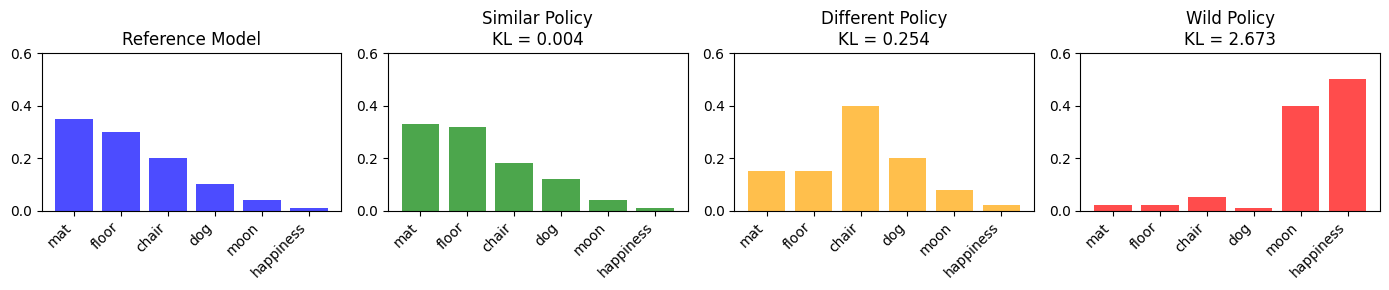

KL Divergence Summary:
  Similar policy (stays close):  KL = 0.0041
  Different policy (drifting):   KL = 0.2541
  Wild policy (gone off rails):  KL = 2.6733

In RLHF, we penalize high KL divergence to prevent the model
from drifting too far from sensible behavior.


In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_kl_divergence_example():
    """
    Let's visualize what KL divergence measures.
    
    Imagine two models predicting the next word after "The cat sat on the"
    """
    # Vocabulary of possible next words
    vocab = ["mat", "floor", "chair", "dog", "moon", "happiness"]
    
    # Reference model's predictions (probabilities)
    # It thinks "mat" and "floor" are most likely
    ref_probs = torch.tensor([0.35, 0.30, 0.20, 0.10, 0.04, 0.01])
    
    # Three scenarios for the policy model:
    
    # Scenario 1: Policy agrees with reference (low KL)
    policy_similar = torch.tensor([0.33, 0.32, 0.18, 0.12, 0.04, 0.01])
    
    # Scenario 2: Policy slightly different (medium KL)
    policy_different = torch.tensor([0.15, 0.15, 0.40, 0.20, 0.08, 0.02])
    
    # Scenario 3: Policy wildly different (high KL)
    policy_wild = torch.tensor([0.02, 0.02, 0.05, 0.01, 0.40, 0.50])
    
    # Compute KL divergence for each
    # KL(P||Q) = sum(P * log(P/Q))
    def kl_div(p, q):
        return (p * (p.log() - q.log())).sum().item()
    
    kl_similar = kl_div(policy_similar, ref_probs)
    kl_different = kl_div(policy_different, ref_probs)
    kl_wild = kl_div(policy_wild, ref_probs)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    x = np.arange(len(vocab))
    
    axes[0].bar(x, ref_probs.numpy(), color='blue', alpha=0.7)
    axes[0].set_title('Reference Model')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(vocab, rotation=45, ha='right')
    axes[0].set_ylim(0, 0.6)
    
    axes[1].bar(x, policy_similar.numpy(), color='green', alpha=0.7)
    axes[1].set_title(f'Similar Policy\nKL = {kl_similar:.3f}')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(vocab, rotation=45, ha='right')
    axes[1].set_ylim(0, 0.6)
    
    axes[2].bar(x, policy_different.numpy(), color='orange', alpha=0.7)
    axes[2].set_title(f'Different Policy\nKL = {kl_different:.3f}')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(vocab, rotation=45, ha='right')
    axes[2].set_ylim(0, 0.6)
    
    axes[3].bar(x, policy_wild.numpy(), color='red', alpha=0.7)
    axes[3].set_title(f'Wild Policy\nKL = {kl_wild:.3f}')
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(vocab, rotation=45, ha='right')
    axes[3].set_ylim(0, 0.6)
    
    plt.tight_layout()
    plt.show()
    
    print("KL Divergence Summary:")
    print(f"  Similar policy (stays close):  KL = {kl_similar:.4f}")
    print(f"  Different policy (drifting):   KL = {kl_different:.4f}")
    print(f"  Wild policy (gone off rails):  KL = {kl_wild:.4f}")
    print()
    print("In RLHF, we penalize high KL divergence to prevent the model")
    print("from drifting too far from sensible behavior.")

compute_kl_divergence_example()

## RLHF vs DPO: A Quick Preview

Before we wrap up, I should mention there's actually an alternative to RLHF that's become very popular: **DPO (Direct Preference Optimization)**.

Remember how RLHF requires four models and a complex training loop? DPO achieves similar results with just two models and a much simpler process. It's kind of like the difference between building a custom race car (RLHF) versus buying a sports car off the lot (DPO). both get you speed, but one requires a lot more work.

| Aspect | RLHF with PPO | DPO |
|--------|---------------|-----|
| **Models needed** | 4 (policy, reference, reward, value) | 2 (policy, reference) |
| **Training stages** | 3 (SFT → Reward Model → RL) | 2 (SFT → DPO) |
| **Complexity** | High | Low |
| **Memory requirements** | Very high | Moderate |
| **Flexibility** | Can experiment with rewards | Fixed objective |

We'll cover DPO in detail later. For now, just know it exists and is often the practical choice for teams without massive compute budgets.

## Summary: What We've Learned

Okay, let's recap because we covered a lot:

**RLHF (Reinforcement Learning from Human Feedback)** is a technique for teaching language models not just to follow instructions, but to follow them *well*. It's the difference between compliance and excellence.

**The three stages:**
1. **SFT**: Teach the model to follow instructions (covered in earlier notebooks)
2. **Reward Model**: Train a model to recognize quality (also covered earlier)
3. **RL Training**: Use rewards to improve the policy (what this notebook is about)

**PPO (Proximal Policy Optimization)** is the algorithm we use for stage 3. The key ideas:
- **Policy** = the model's strategy for generating text
- **Proximal** = make small, careful updates (don't change too much at once)
- **Optimization** = get better at generating high-reward responses

**The four models:**
1. **Policy Model**: What we're training
2. **Reference Model**: Frozen copy to prevent drift
3. **Reward Model**: Scores responses (frozen)
4. **Value Network**: Predicts expected rewards (helps learning)

**KL divergence** keeps the policy from drifting too far from the reference. Without it, models can "hack" the reward by finding weird outputs that score well but are actually terrible.

In the next notebooks, we'll dive deeper into the PPO algorithm itself, see the actual training loop, and understand the math behind why it works.